*I tried to predict a spam mail with finetuning a DistilBert based Tensorflow model.*

* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words),
* Used tf.data pipeline for efficient training,
* I only used only 20 max length for sequence length (bert models support up to 512 input lengths),
* Only 18000 samples be used for training (12000 samples for validating and 20000 samples for testing),


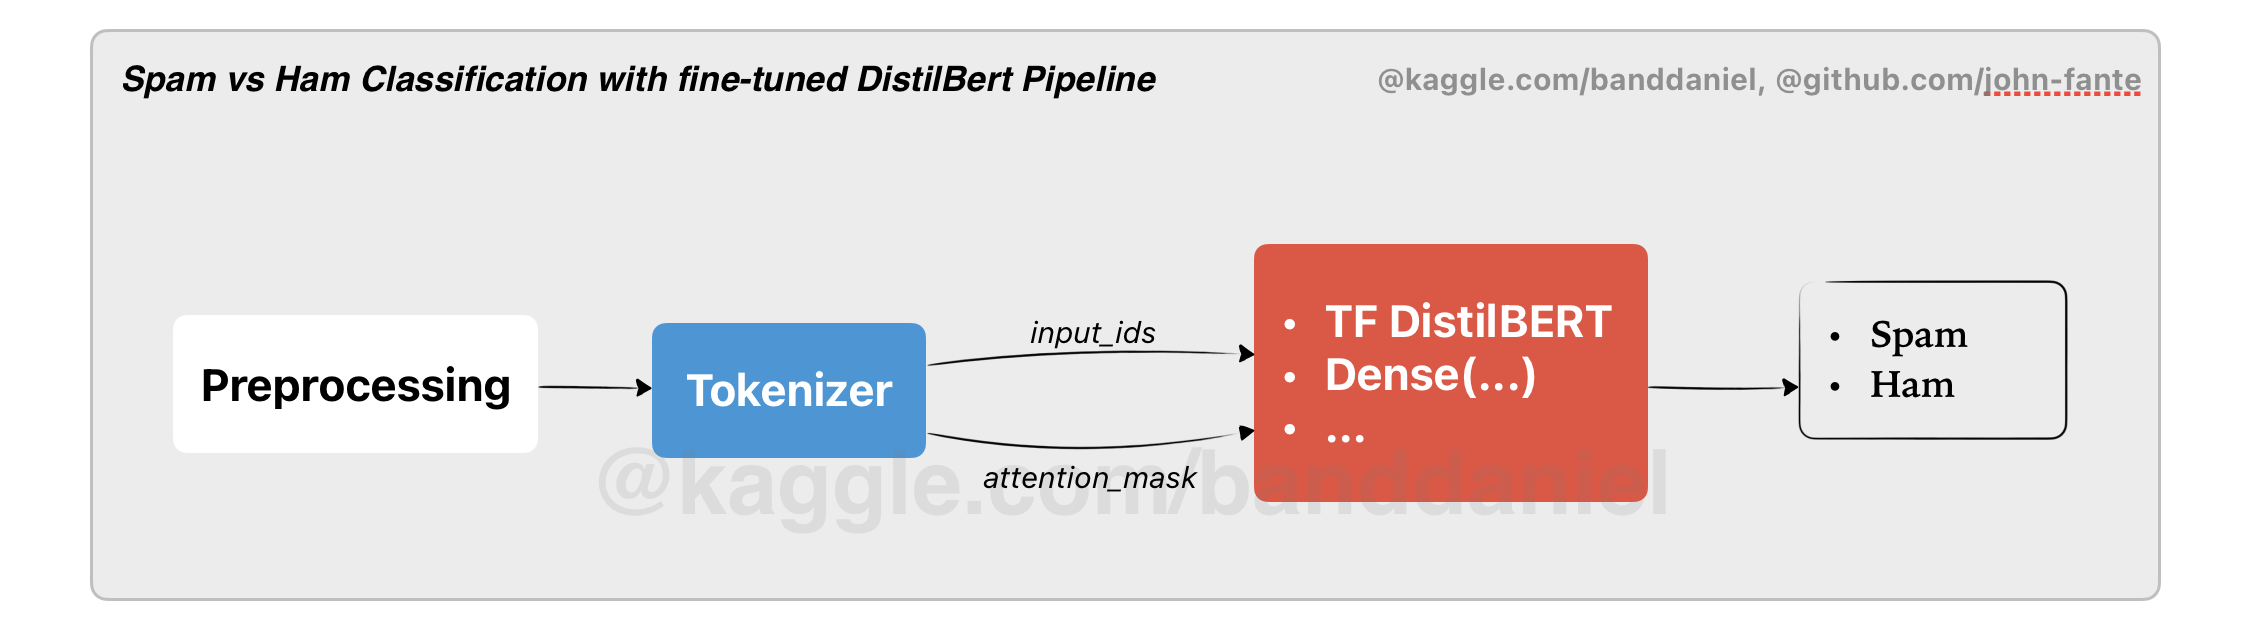

## My Another Projects
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Rating Prediction w/SentenceTransformer, CatBoost](https://www.kaggle.com/code/banddaniel/rating-prediction-w-sentencetransformer-catboost)


## References
1. https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
2. https://www.kaggle.com/code/preatcher/emotion-detection-by-using-bert

In [1]:
# downgrade tensorflow for using huggingface distilbert model as embedding

from IPython.display import clear_output
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0
!pip install --user -U nltk spacy
clear_output()

In [2]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *

from transformers import AutoTokenizer, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig


SEED = 500
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

In [3]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distil_bert = TFDistilBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
data = pd.read_csv('/kaggle/input/190k-spam-ham-email-dataset-for-classification/spam_Emails_data.csv')
data.drop_duplicates(subset = ['text'], inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data = data[:50000] # I only use 50000 samples due to the complexity problem
data.head()

,label,text
0,Spam,you registered to receive this and similar off...
1,Ham,would it be unreasonable to require one cent i...
2,Ham,market notice january escapenumber escapenumbe...
3,Spam,hi get yescapenumberur hard rescapenumberck es...
4,Spam,how are you today i am dr thomas fernandez a c...


In [5]:
data.shape

(50000, 2)

# <span style="color:#e74c3c;"> Preprocessing </span>

In [6]:
# preprocessing functions

stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = full_data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

# label encoding
le = LabelEncoder()
full_data['encoded_label'] = le.fit_transform(full_data['label'].tolist())

In [7]:
# after preprocessing functions
full_data.head()

,label,text,preprocessed_text,encoded_label
0,Spam,you registered to receive this and similar off...,registered receive similar offers youve heard ...,1
1,Ham,would it be unreasonable to require one cent i...,would unreasonable require one cent increments...,0
2,Ham,market notice january escapenumber escapenumbe...,market notice january escapenumber escapenumbe...,0
3,Spam,hi get yescapenumberur hard rescapenumberck es...,hi get yescapenumberur hard rescapenumberck es...,1
4,Spam,how are you today i am dr thomas fernandez a c...,today dr thomas fernandez consultant cardiolog...,1


In [8]:
# classes
full_data['label'].value_counts()

label
Ham     26384
Spam    23616
Name: count, dtype: int64

# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [9]:
# train and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.4, random_state = SEED, stratify = full_data['encoded_label'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.4, random_state = SEED, stratify = train_val_data['encoded_label'])


print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 18000
val samples :	 12000
test samples :	 20000


# <span style="color:#e74c3c;"> Tokenizing </span>

In [10]:
MAX_LEN = 20

X_train = tokenizer(text=train_data['preprocessed_text'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_valid = tokenizer(text=val_data['preprocessed_text'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_test = tokenizer(text=test_data['preprocessed_text'].tolist()[:40000], add_special_tokens=True,
                   max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                   return_token_type_ids=False, return_attention_mask=True, verbose=True)

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [11]:
# a function for tf.data pipeline
def parsing(text, label):
    input_ids = text['input_ids']
    attention_mask = text['attention_mask']
    
    return {'input_ids': input_ids, 'attention_mask' : attention_mask}, label

In [12]:
# tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((X_train, train_data['encoded_label']))
train_dataset = (train_loader.map(parsing, num_parallel_calls = AUTO).shuffle(BATCH_SIZE*20).batch(BATCH_SIZE).prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((X_valid, val_data['encoded_label']))
valid_dataset = (valid_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, test_data['encoded_label']))
test_dataset = (test_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# <span style="color:#e74c3c;"> Fine-tuning TFDistilBert </span>  Model

In [13]:
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
embeddings = distil_bert(input_ids, attention_mask = input_mask)[0] 

X = GlobalMaxPool1D()(embeddings)
X = Dense(128, activation='gelu')(X)
X = Dropout(0.3)(X)
X = Dense(32,activation = 'gelu')(X)
X = Dropout(0.1)(X)
out = Dense(2,activation = 'softmax')(X)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=out)

# for distilbert tuning
model.layers[2].trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05), loss = tf.keras.losses.SparseCategoricalCrossentropy(),  metrics = ['acc'] )
model.summary()

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 1, min_delta = 0.001),
                tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model.best.weights.h5', save_best_only=True, save_weights_only=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 20, 768),                                                    
                                 hidden_states=None                                           

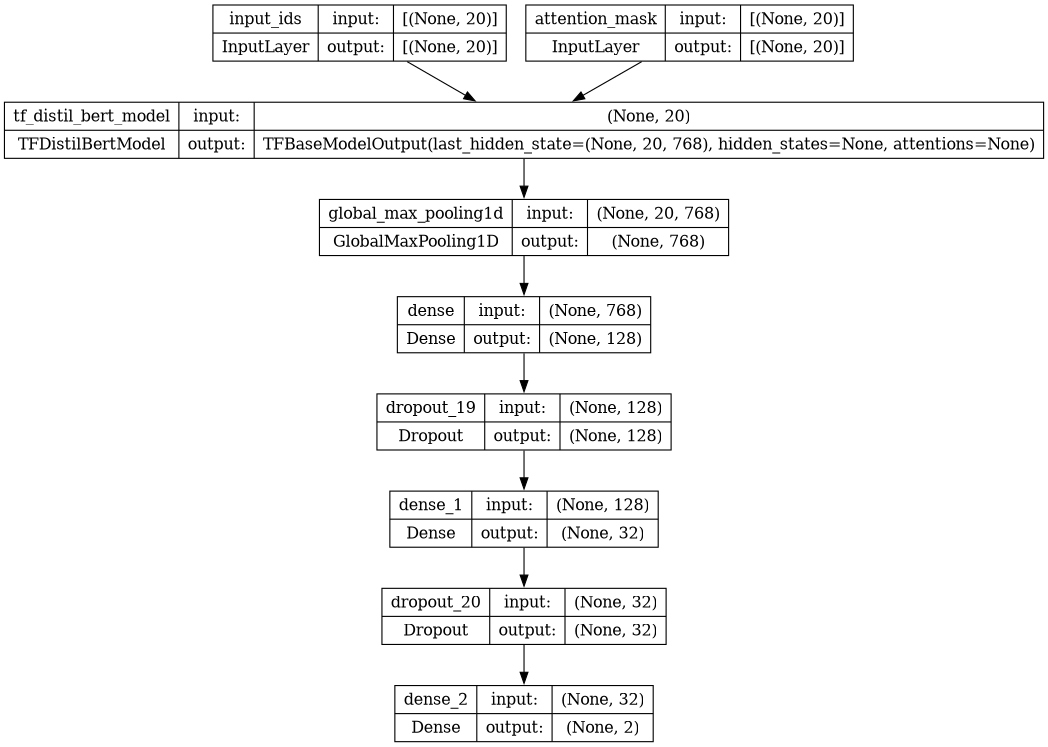

In [14]:
# plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [15]:
# training
hist = model.fit(train_dataset, validation_data = valid_dataset, epochs = 2, callbacks = my_callbacks)

Epoch 1/2
282/282 [==============================] - 750s 3s/step - loss: 0.2479 - acc: 0.8972 - val_loss: 0.1582 - val_acc: 0.9361
Epoch 2/2
282/282 [==============================] - 731s 3s/step - loss: 0.0849 - acc: 0.9694 - val_loss: 0.2748 - val_acc: 0.9252


# <span style="color:#e74c3c;"> Test </span>  Predictions

In [16]:
# test predictions
pred = model.predict(test_dataset)
test_pred = np.argmax(pred, axis = 1)
y_test = test_data['encoded_label'].values

313/313 [==============================] - 186s 590ms/step


In [17]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true, y_pred, target_names = list(le.classes_)):
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = target_names, values_format = '2g', cmap = 'bone', colorbar = False)

Mean Squared Error :	0.07500
Weighted F1 Score :	0.924
Accuracy Score :	92.500 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

         Ham       0.88      0.99      0.93     10554
        Spam       0.98      0.86      0.92      9446

    accuracy                           0.93     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93      0.93      0.92     20000

----------------------------------------------------------------------

 Confusion Matrix: 



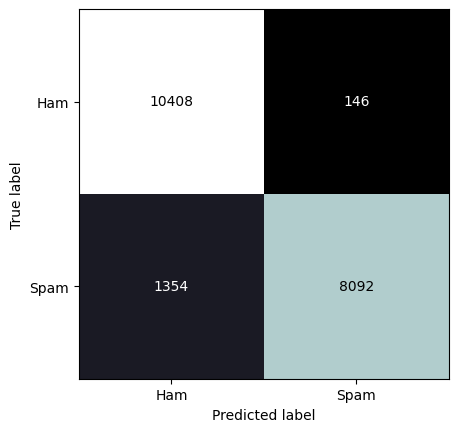

In [18]:
plot_prediction_results(y_test, test_pred)